# Сравнение моделей и выбор итоговой модели

Этот ноутбук сравнивает **Logistic Regression** и **Random Forest**.

Установка необходимых пакетов _(узнал, что можно сделать так, вот и решил попробовать новый спрособ устрановки)_

In [21]:
import sys, subprocess
packages = ['pandas','scikit-learn','matplotlib','seaborn','nltk','razdel','joblib']
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet'] + packages)
print('Пакеты установлены или уже были установлены: ', packages)

Пакеты установлены или уже были установлены:  ['pandas', 'scikit-learn', 'matplotlib', 'seaborn', 'nltk', 'razdel', 'joblib']


Импорты и проверка файлов в рабочей директории

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
from razdel import tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk, re

# Загрузка стоп-слов
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

print('Файлы в текущей папке (csv, joblib):')
print([f for f in os.listdir('.') if f.endswith('.csv') or f.endswith('.joblib') or f.endswith('.pkl')])

Файлы в текущей папке (csv, joblib):
['model_saved.joblib', 'test.csv', 'test_labeled.csv', 'train.csv']


Предобработки текста

In [23]:
stemmer = SnowballStemmer('russian')
RUSSIAN_STOPWORDS = set(stopwords.words('russian'))

def preprocess_text(text):
    # Приводим к строке и к нижнему регистру
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # Убираем URL и email
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    # Оставляем только буквы и пробелы (русские + латинские)
    text = re.sub(r'[^\w\sёа-яА-Я\-]', ' ', text)
    tokens = [t.text for t in tokenize(text)]
    stems = []
    for tok in tokens:
        if tok.isdigit() or len(tok) < 2:
            continue
        s = stemmer.stem(tok)
        if s in RUSSIAN_STOPWORDS:
            continue
        stems.append(s)
    return ' '.join(stems)

Загрузка датасета

In [24]:
DATA_PATH = 'train.csv' 
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'Файл {DATA_PATH} не найден в текущей директории. Поместите файл рядом с ноутбуком.')

df = pd.read_csv(DATA_PATH)
print(f'Файл {DATA_PATH} загружен, форма: {df.shape}')
display(df.head())

Файл train.csv загружен, форма: (7000, 2)


,comment,toxic
0,Мастер вообще не знает свою работу.,1
1,"Классный сервис, приду ещё!",0
2,Работа выполнена на высоком уровне.,0
3,"Спасибо за работу, все отлично!",0
4,Мастер вообще не знает свою работу.,1


Предобработка текста

In [25]:
print('Запускаю предобработку комментариев (может занять время)...')
df['comment_proc'] = df['comment'].fillna('').astype(str).apply(preprocess_text)
print('Предобработка завершена. Примеры:')
display(df[['comment','comment_proc']].head(6))

Запускаю предобработку комментариев (может занять время)...
Предобработка завершена. Примеры:


,comment,comment_proc
0,Мастер вообще не знает свою работу.,мастер вообщ знает сво работ
1,"Классный сервис, приду ещё!",классн сервис прид ещ
2,Работа выполнена на высоком уровне.,работ выполн высок уровн
3,"Спасибо за работу, все отлично!",спасиб работ отличн
4,Мастер вообще не знает свою работу.,мастер вообщ знает сво работ
5,Все сделали быстро и качественно.,сдела быстр качествен


In [ ]:
# Разделение данных на train/test
X = df['comment_proc']
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Размеры: Train = {X_train.shape[0]}, Test = {X_test.shape[0]}')

Размеры: Train = 5600, Test = 1400


Загрузка модели LR

In [27]:
possible_names = ['model_saved.joblib']
loaded_lr = None
for name in possible_names:
    if os.path.exists(name):
        try:
            loaded_lr = joblib.load(name)
            print(f'Успешно загружена предоставленная модель из файла: {name}')
            break
        except Exception as e:
            print(f'Файл {name} найден, но не удалось загрузить: {e}')

if loaded_lr is None:
    print('Предоставленная модель не найдена. Будет обучена новая Logistic Regression на данных.')
    # Обучим LR на наших данных (в этом ноутбуке)
    pipeline_lr = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('clf', LogisticRegression(max_iter=500))])
    pipeline_lr.fit(X_train, y_train)
    loaded_lr = pipeline_lr
    print('Новая модель Logistic Regression обучена на train-части.')
else:
    print('Проверяю модель на тестовой выборке...')

Успешно загружена предоставленная модель из файла: model_saved.joblib
Проверяю модель на тестовой выборке...


Оценка LR

In [28]:
pred_lr = loaded_lr.predict(X_test)
prob_lr = None
try:
    if hasattr(loaded_lr.named_steps['clf'], 'predict_proba'):
        prob_lr = loaded_lr.predict_proba(X_test)[:,1]
    else:
        # fallback для моделей без predict_proba
        prob_lr = loaded_lr.decision_function(X_test)
except Exception as e:
    print('Не удалось получить predict_proba/decision_function у LR:', e)

acc_lr = accuracy_score(y_test, pred_lr)
f1_lr = f1_score(y_test, pred_lr)
roc_auc_lr = None
if prob_lr is not None:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, prob_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)

print(f'LR — Точность (Accuracy): {acc_lr:.4f}, F1 (toxic): {f1_lr:.4f}, ROC-AUC: {roc_auc_lr}')

LR — Точность (Accuracy): 0.6521, F1 (toxic): 0.4666, ROC-AUC: 0.7967520408163264


RF

In [29]:
# Обучаем для сравнения (TF-IDF + RF)
print('Обучение Random Forest (может занять некоторое время)...')
pipeline_rf = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
pipeline_rf.fit(X_train, y_train)
pred_rf = pipeline_rf.predict(X_test)
prob_rf = pipeline_rf.predict_proba(X_test)[:,1]

acc_rf = accuracy_score(y_test, pred_rf)
f1_rf = f1_score(y_test, pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f'RF — Точность (Accuracy): {acc_rf:.4f}, F1 (toxic): {f1_rf:.4f}, ROC-AUC: {roc_auc_rf:.4f}')

Обучение Random Forest (может занять некоторое время)...
RF — Точность (Accuracy): 1.0000, F1 (toxic): 1.0000, ROC-AUC: 1.0000


### Отчёты

In [30]:
print('=== Отчёт для Logistic Regression ===')
print(classification_report(y_test, pred_lr, digits=4))
print('\n=== Отчёт для Random Forest ===')
print(classification_report(y_test, pred_rf, digits=4))

# Таблица-сводка по метрикам
summary = pd.DataFrame({
    'Модель': ['Logistic Regression (предоставленная)', 'Random Forest'],
    'Accuracy': [round(acc_lr,4), round(acc_rf,4)],
    'F1_toxic': [round(f1_lr,4), round(f1_rf,4)],
    'ROC_AUC': [round(roc_auc_lr,4) if roc_auc_lr is not None else None, round(roc_auc_rf,4)]
})
display(summary)

=== Отчёт для Logistic Regression ===
              precision    recall  f1-score   support

           0     0.5897    1.0000    0.7419       700
           1     1.0000    0.3043    0.4666       700

    accuracy                         0.6521      1400
   macro avg     0.7949    0.6521    0.6043      1400
weighted avg     0.7949    0.6521    0.6043      1400


=== Отчёт для Random Forest ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       700
           1     1.0000    1.0000    1.0000       700

    accuracy                         1.0000      1400
   macro avg     1.0000    1.0000    1.0000      1400
weighted avg     1.0000    1.0000    1.0000      1400



,Модель,Accuracy,F1_toxic,ROC_AUC
0,Logistic Regression (предоставленная),0.6521,0.4666,0.7968
1,Random Forest,1.0000,1.0000,1.0000


ROC-AUC

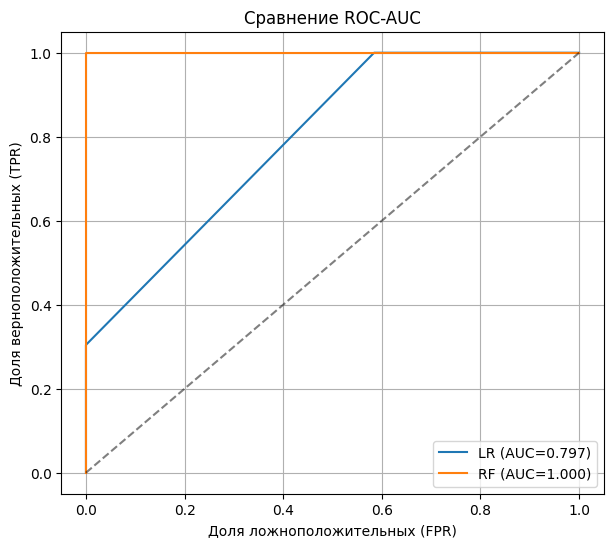

In [31]:
plt.figure(figsize=(7,6))
if prob_lr is not None:
    plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('Доля ложноположительных (FPR)'); plt.ylabel('Доля верноположительных (TPR)')
plt.title('Сравнение ROC-AUC')
plt.legend(); plt.grid(True); plt.show()

Confusion matrix

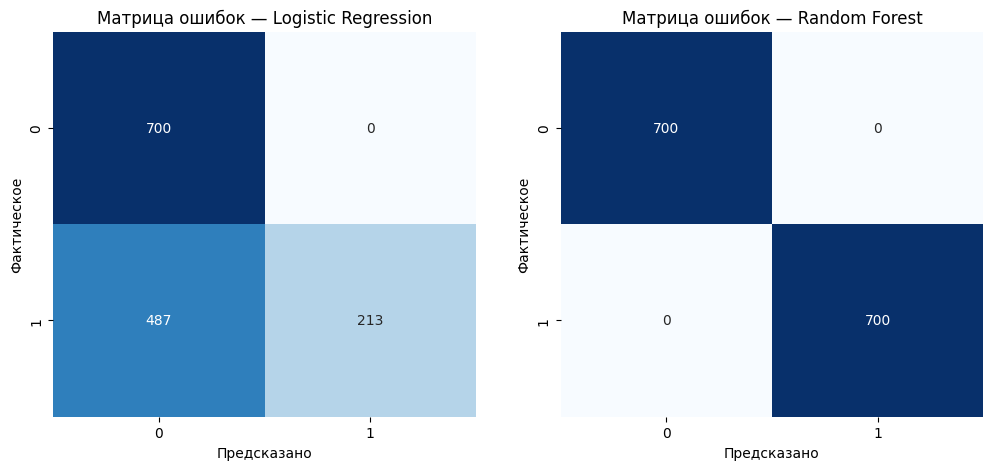

In [32]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
cm_lr = confusion_matrix(y_test, pred_lr)
cm_rf = confusion_matrix(y_test, pred_rf)

sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title('Матрица ошибок — Logistic Regression')
axes[0].set_xlabel('Предсказано'); axes[0].set_ylabel('Фактическое')

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar=False)
axes[1].set_title('Матрица ошибок — Random Forest')
axes[1].set_xlabel('Предсказано'); axes[1].set_ylabel('Фактическое')

plt.show()

Важность признаков

Топ-20 признаков для Logistic Regression (положительные коэффициенты указывают на токсичность):
не 4.7037
ужасная 3.0233
переделывать 3.0233
делают 2.9924
разочарован 2.6109
отвратительное 2.6109
качество 2.6109
некомпетентные 2.5601
сотрудники 2.5601
совсем 2.5601
нуля 2.5191
ниже 2.5191
ветер 2.5191
деньги 2.5191
свою 2.2723
знает 2.2723
вообще 2.2723
испортили 2.2122
хамское 2.2122
настроение 2.2122


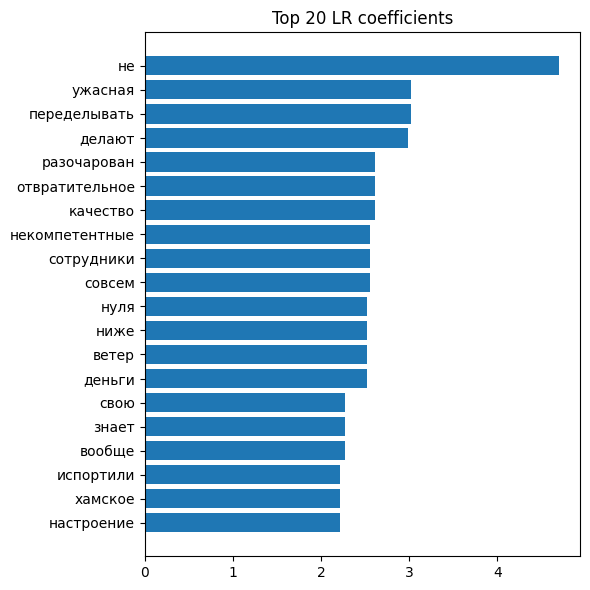


Топ-20 признаков для Random Forest (важности):
отличн 0.081249
хорош 0.069677
очен 0.062397
обслуживан 0.04514
дела 0.040141
полн 0.030695
сдела 0.027395
качествен 0.025344
уровн 0.025283
выполн 0.025053
результат 0.023119
прид 0.021706
высок 0.020864
быстр 0.020796
работ 0.020793
сервис 0.020506
классн 0.019004
рекоменд 0.017691
переделыва 0.017422
вежлив 0.017419


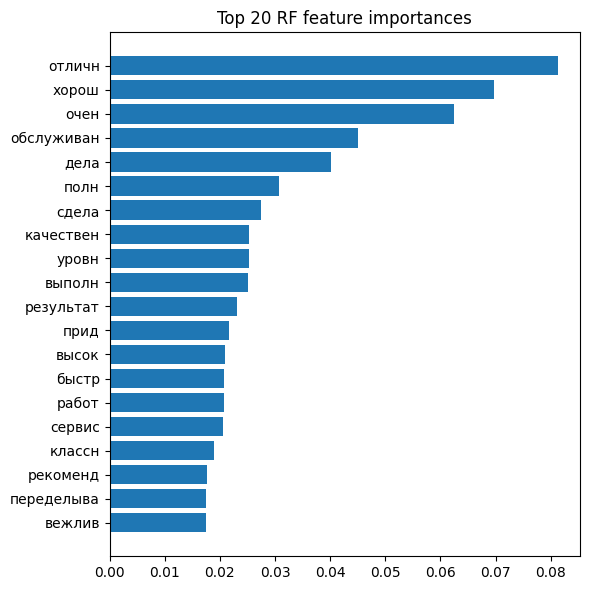

In [33]:
# Важность признаков: для LR — коэффициенты, для RF — feature_importances
print('Топ-20 признаков для Logistic Regression (положительные коэффициенты указывают на токсичность):')
try:
    vec_lr = loaded_lr.named_steps['tfidf']
    coef_lr = loaded_lr.named_steps['clf'].coef_[0]
    feat_names_lr = vec_lr.get_feature_names_out()
    top_idx_lr = np.argsort(coef_lr)[-20:][::-1]
    for i in top_idx_lr:
        print(feat_names_lr[i], round(coef_lr[i],4))
    # график
    names = [feat_names_lr[i] for i in top_idx_lr][::-1]
    vals = [coef_lr[i] for i in top_idx_lr][::-1]
    plt.figure(figsize=(6,6))
    plt.barh(names, vals); plt.title('Top 20 LR coefficients'); plt.tight_layout(); plt.show()
except Exception as e:
    print('Не удалось извлечь коэффициенты LR:', e)

print('\nТоп-20 признаков для Random Forest (важности):')
try:
    vec_rf = pipeline_rf.named_steps['tfidf']
    rf_clf = pipeline_rf.named_steps['clf']
    feat_names_rf = vec_rf.get_feature_names_out()
    importances = rf_clf.feature_importances_
    top_idx_rf = np.argsort(importances)[-20:][::-1]
    for i in top_idx_rf:
        print(feat_names_rf[i], round(importances[i],6))
    names = [feat_names_rf[i] for i in top_idx_rf][::-1]
    vals = [importances[i] for i in top_idx_rf][::-1]
    plt.figure(figsize=(6,6))
    plt.barh(names, vals); plt.title('Top 20 RF feature importances'); plt.tight_layout(); plt.show()
except Exception as e:
    print('Не удалось извлечь важности признаков RF:', e)